<a href="https://colab.research.google.com/github/saranya-pujari/DeepONet_Practice/blob/main/DeepONet_RT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepONet - Diffusion Reaction (No PI)

In [36]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian, lax
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
%matplotlib inline

## Neural network and model creation (think DeepONet_model)

In [37]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [38]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers):
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)  # jax.nn.relu
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)     # or Relu

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3,
                                                                      decay_steps=2000,
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T, axis=-1)
        return  outputs

    # Define operator loss
    def loss_operator(self, params, batch):
        inputs, outputs = batch
        s, z = inputs
        # Compute forward pass
        j_pred = vmap(self.operator_net, (None, 0, 0))(params, s, z)
        # Compute loss
        loss = np.mean((outputs.flatten() - j_pred.flatten())**2)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_operator)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        # Define data iterators
        data_iterator = iter(dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            batch = next(data_iterator)

            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute loss
                loss_value = self.loss_operator(params, batch)

                # Store loss
                self.loss_log.append(loss_value)

                # Print loss
                pbar.set_postfix({'Loss': loss_value})

    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_j(self, params, S_star, Z_star):
        j_pred = vmap(self.operator_net, (None, 0, 0))(params, S_star, Z_star)
        return j_pred

## Dataset generation & PDE solver

In [39]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, s, z, j,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.s = s # input sample
        self.z = z # location
        self.j = j # labeled data evulated at z (solution measurements, BC/IC conditions, etc.)

        self.N = s.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        z = self.z[idx,:]
        j = self.j[idx,:]
        # Construct batch
        inputs = (s, z)
        outputs = j
        return inputs, outputs

PDE Solver

In [40]:
def tridiag(a, b, c, r):
    n = len(a)
    u = np.zeros(n, dtype=float)
    gamma = np.zeros(n, dtype=float)

    beta = lax.cond(
        b[0] == 0.0,
        lambda _: np.nan,
        lambda _: b[0],
        operand=None
    )
    u = u.at[0].set(r[0] / beta)

    for j in range(1, n):
        gamma = gamma.at[j].set(c[j - 1] / beta)
        beta = b[j] - a[j] * gamma[j]
        beta = lax.cond(
            beta == 0.0,
            lambda _: np.nan,
            lambda _: beta,
            operand=None
        )
        u = u.at[j].set((r[j] - a[j] * u[j - 1]) / beta)

    for j in range(n - 2, 0, -1):
        u = u.at[j].set(u[j] - gamma[j + 1] * u[j + 1])

    return u

def lambda_iteration(alpha, eps, n_iter, Nz, use_tridiag=False, ng=False):
    nzi = Nz + 1
    nzc = Nz
    mu = 1.0 / np.sqrt(3.0)

    # Optical depth grid
    zi = np.linspace(0, 1, nzi)
    zc = 0.5 * (zi[:-1] + zi[1:])
    dz = np.diff(zi)

    bnu = np.ones(nzi)
    dtau = alpha * dz / mu

    dtaui = np.zeros(nzi)
    dtaui = dtaui.at[1:-1].set(0.5 * (dtau[1:] + dtau[:-1]))
    dtaui = dtaui.at[0].set(2 * dtaui[1] - dtaui[2])
    dtaui = dtaui.at[-1].set(2 * dtaui[-2] - dtaui[-3])

    # Source Function
    dmt_a   = np.zeros(nzi)
    dmt_b   = np.ones(nzi)
    dmt_c   = np.zeros(nzi)
    drs     = np.ones(nzi)

    for i in range (1, nzi - 1):
        dmt_a = dmt_a.at[i].set(-1.0 / (dtaui[i] * dtau[i - 1]))
        dmt_b = dmt_b.at[i].set(eps + 1.0 / (dtaui[i] * dtau[i - 1]) + 1.0 / (dtaui[i] * dtau[i]))
        dmt_c = dmt_c.at[i].set(-1.0 / (dtaui[i] * dtau[i]))
        drs = drs.at[i].set(eps * bnu[i])

    dmt_a = dmt_a.at[0].set(0)
    dmt_b = dmt_b.at[0].set(1)
    dmt_c = dmt_c.at[0].set(0)
    drs = drs.at[0].set(bnu[0])

    dmt_a = dmt_a.at[-1].set(-1.0 / dtau[-1])
    dmt_b = dmt_b.at[-1].set(1.0 / dtau[-1] + 1.0)
    dmt_c = dmt_c.at[-1].set(0.0)
    drs   = drs.at[-1].set(0.0)

    j_diff = tridiag(dmt_a, dmt_b, dmt_c, drs)
    s_diff = eps * bnu + (1 - eps) * j_diff
    s_diff = s_diff[:-1]
    j_diff = j_diff[:-1]
    return j_diff, s_diff



Sample generation

In [41]:
def alpha(alpha0, alpha1, Nz):
    zi = np.linspace(0, 1, Nz + 1)
    zc = 0.5 * (zi[:-1] + zi[1:])
    return np.exp(np.log(alpha0) + (np.log(alpha1) - np.log(alpha0)) * zc)

# A radiative transfer numerical solver
def solve_RTE(key, Nz, P, eps):
    # Split key into subkeys for each random draw
    key_eps, key_a0, key_a1, key_idx = random.split(key, 4)

    if eps == None:
      exp = random.uniform(key_eps, shape=(), minval=-4, maxval=-1)
      eps = 10 ** exp
    alpha0 = 1e5
    alpha1 = 1e-1

    zi = np.linspace(0, 1, Nz + 1)
    zc = 0.5 * (zi[:-1] + zi[1:])
    alpha_z = alpha(alpha0, alpha1, Nz)

    j_z, s_z = lambda_iteration(alpha_z, eps, 50, Nz)

    idx = random.choice(key_idx, Nz, shape=(P,), replace=False)
    z = zc[idx][:, None]
    j = j_z[idx]
    s = s_z
    return (zc, j_z), (s, z, j), eps

# Generate training data corresponding to one input sample
def generate_one_training_data(key, P):
    (zc, j_z), (s, z, j), eps = solve_RTE(key, Nz, P, eps=None)
    s = np.tile(s, (P, 1))
    return s, z, j, eps

# Generate training data corresponding to N input sample
def generate_training_data(key, N, P):
    jax.config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    s_train, z_train, j_train, eps_train = vmap(generate_one_training_data, (0, None))(keys, P)

    s_train = np.float32(s_train.reshape(N * P, -1))
    z_train = np.float32(z_train.reshape(N * P, -1))
    j_train = np.float32(j_train.reshape(N * P, -1))
    eps_train = np.float32(eps_train.reshape(N, -1))
    jax.config.update("jax_enable_x64", False)

    return s_train, z_train, j_train, eps_train

# Generate test data corresponding to one input sample
def generate_one_test_data(key, P, eps):
    (zc, j_z), (s, z, j), eps = solve_RTE(key, Nz, P, eps)
    s_test = np.tile(s, (P, 1))
    ZZ = np.meshgrid(zc)[0].flatten()[:, None]
    z_test = ZZ
    j_test = j_z
    return s_test, z_test, j_test

def generate_test_data(key, N, P, eps):
    jax.config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    s_test, z_test, j_test = vmap(generate_one_test_data, (0, None, None))(keys, P, eps)

    s_test = np.float32(s_test.reshape(N * P, -1))
    z_test = np.float32(z_test.reshape(N * P, -1))
    j_test = np.float32(j_test.reshape(N * P, -1))
    jax.config.update("jax_enable_x64", False)
    return s_test, z_test, j_test

# Compute relative l2 error over N test samples.
def compute_error(key, P, eps):
    # Generate one test sample
    s_test, z_test, j_test = generate_test_data(key, 1, P, eps)
    # Predict
    j_pred = model.predict_j(params, s_test, z_test)[:,None]
    # Compute relative l2 error
    error_j = np.linalg.norm(j_test - j_pred) / np.linalg.norm(j_test)
    return error_j

## Set up dataset & model parameters

In [42]:
key = random.PRNGKey(0)

# Resolution of the solution
Nz = 100
N = 5000 # number of input samples
m = Nz   # number of input sensors
P_train = 100 # number of output sensors

s_train, z_train, j_train, eps_train = generate_training_data(key, N, P_train)
print('s_train shape: {}'.format(s_train.shape))
print('z_train shape: {}'.format(z_train.shape))
print('j_train shape: {}'.format(j_train.shape))

s_train shape: (500000, 100)
z_train shape: (500000, 1)
j_train shape: (500000, 1)


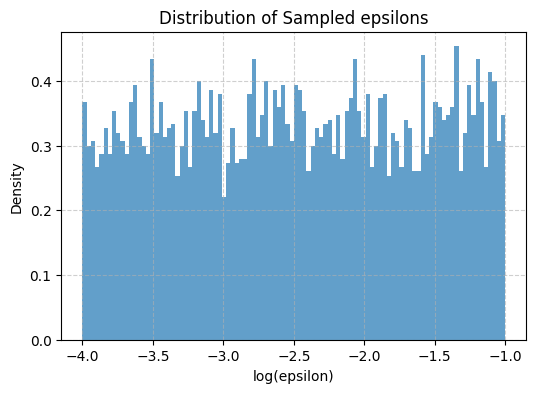

In [43]:
eps_log = np.log10(eps_train)
plt.figure(figsize=(6,4))
plt.hist(eps_log, bins=100, density=True, alpha=0.7)
plt.xlabel("log(epsilon)")
plt.ylabel("Density")
plt.title("Distribution of Sampled epsilons")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

In [44]:
# Initialize model
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [1, 50, 50, 50, 50, 50]
model = DeepONet(branch_layers, trunk_layers)

In [45]:
# Create data set
batch_size = 10000
dataset = DataGenerator(s_train, z_train, j_train, batch_size)

## Run model

In [46]:
# Train
model.train(dataset, nIter=120000)


100%|██████████| 120000/120000 [04:37<00:00, 433.01it/s, Loss=2.7435965e-07]


## Testing & Visualization

In [47]:
# Test data
N_test =100 # number of input samples
P_test = Nz   # number of sensors
key_test = random.PRNGKey(1234567)
keys_test = random.split(key_test, N_test)

# Predict
params = model.get_params(model.opt_state)

# Compute error
error_j = vmap(compute_error, (0, None, None))(keys_test,P_test,None)

print('mean of relative L2 error of s: {:.2e}'.format(error_j.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error_j.std()))

mean of relative L2 error of s: 7.06e-04
std of relative L2 error of s: 2.86e-04


/tmp/ipython-input-1635111999.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


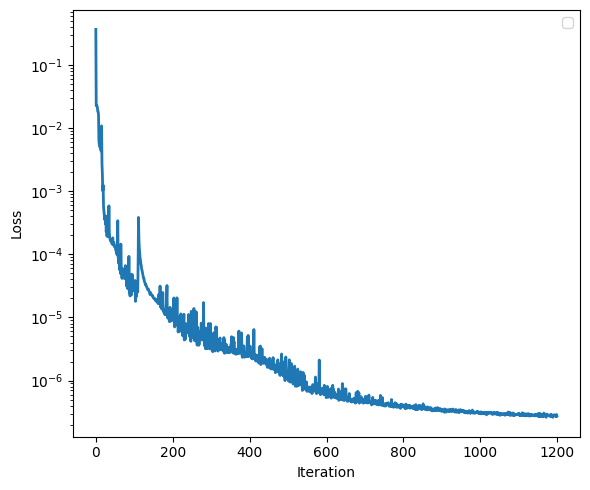

In [48]:
#Plot for loss function
plt.figure(figsize = (6,5))
plt.plot(model.loss_log, lw=2)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
key = random.PRNGKey(123)
P_test = 100
N_test = 1
Nz = 100
m = Nz

s_test, z_test, j_test = generate_test_data(key, N_test, P_test, None)

# Predict
params = model.get_params(model.opt_state)
j_pred = model.predict_j(params, s_test, z_test)

# Create uniform mesh on [0,1] with Nz points
z_uniform = np.linspace(0, 1, Nz)
ZZ = z_uniform[:, None]

# Grid data
J_pred = griddata(z_test, j_pred.flatten(), ZZ, method='cubic')
J_test = griddata(z_test, j_test.flatten(), ZZ, method='cubic')

# Clean up any NaNs from interpolation
mask = ~np.isnan(J_pred) & ~np.isnan(J_test)
ZZ = ZZ[mask]
J_pred = J_pred[mask]
J_test = J_test[mask]

# --- Compute relative L2 error ---
error = np.linalg.norm(J_pred - J_test, 2) / np.linalg.norm(J_test, 2)
print('Relative L2 error: {:.3e}'.format(error))


Relative L2 error: 6.953e-04


<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-268105011.py:21: SyntaxWarning: invalid escape sequence '\m'
  axs[2].set_title('Absolute Error $|j_{\mathrm{pred}} - j_{\mathrm{true}}|$')


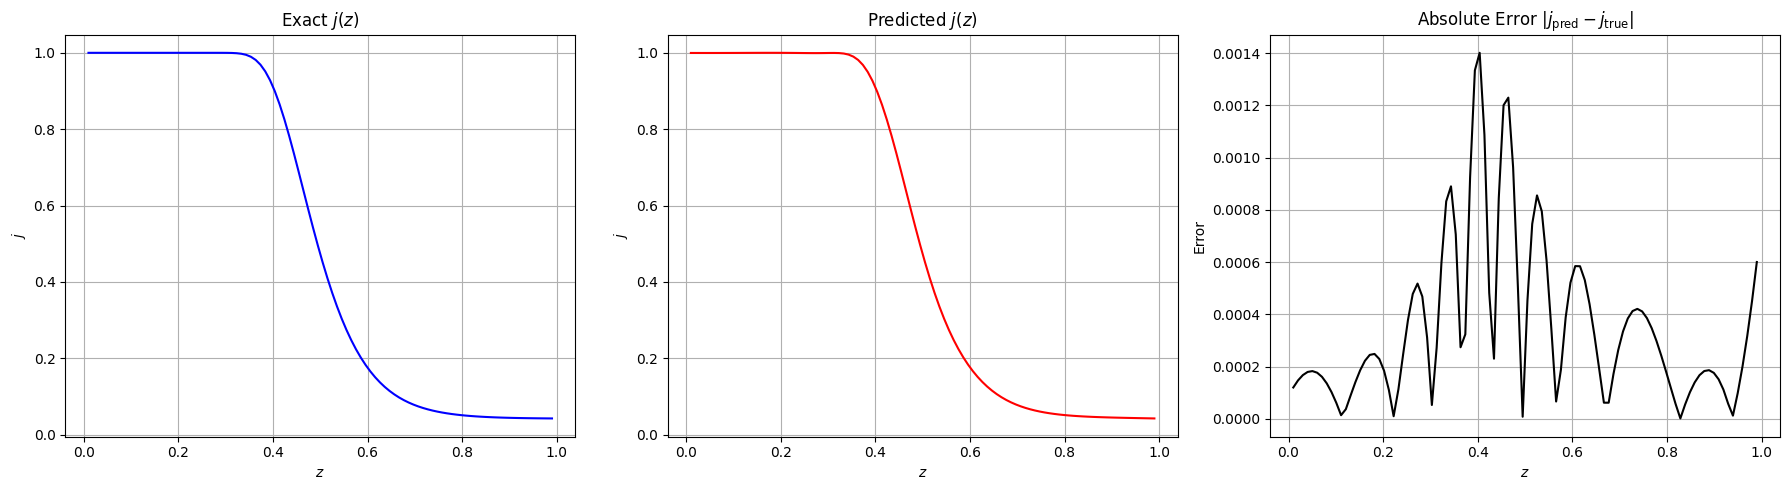

In [56]:
# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
#ZZ = ZZ[1:-1]

# 1. Ground truth
axs[0].plot(ZZ, J_test, label='True', color='blue')
axs[0].set_title('Exact $j(z)$')
axs[0].set_xlabel('$z$')
axs[0].set_ylabel('$j$')
axs[0].grid(True)

# 2. Prediction
axs[1].plot(ZZ, J_pred, label='Predicted', color='red')
axs[1].set_title('Predicted $j(z)$')
axs[1].set_xlabel('$z$')
axs[1].set_ylabel('$j$')
axs[1].grid(True)

# 3. Absolute error
axs[2].plot(ZZ, np.abs(J_pred - J_test), label='|Error|', color='black')
axs[2].set_title('Absolute Error $|j_{\mathrm{pred}} - j_{\mathrm{true}}|$')
axs[2].set_xlabel('$z$')
axs[2].set_ylabel('Error')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [57]:
def visualize(eps):
    key = random.PRNGKey(123)
    P_test = 100
    N_test = 1
    Nz = 100
    m = Nz

    s_test, z_test, j_test = generate_test_data(key, N_test, P_test, eps)

    # Predict
    params = model.get_params(model.opt_state)
    j_pred = model.predict_j(params, s_test, z_test)

    # Create uniform mesh on [0,1] with Nz points
    z_uniform = np.linspace(0, 1, Nz)
    ZZ = z_uniform[:, None]

    # Grid data (interpolated onto ZZ)
    J_pred = griddata(z_test, j_pred.flatten(), ZZ, method='cubic')
    J_test = griddata(z_test, j_test.flatten(), ZZ, method='cubic')

    # Clean up any NaNs from interpolation
    mask = ~np.isnan(J_pred) & ~np.isnan(J_test)
    ZZ = ZZ[mask].flatten()
    J_pred = J_pred[mask]
    J_test = J_test[mask]

    # --- Compute relative L2 error ---
    error = np.linalg.norm(J_pred - J_test, 2) / np.linalg.norm(J_test, 2)
    print('Relative L2 error: {:.3e}'.format(error))

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # 1. Exact vs Predicted
    axs[0].plot(ZZ, J_test, label='Exact', color='blue', linewidth=2)
    axs[0].plot(ZZ, J_pred, label='Predicted', color='red', linewidth=2)
    axs[0].set_title(f"$j(z)$, Epsilon = {eps}", fontsize=18)
    axs[0].set_xlabel('$z$', fontsize=16)
    axs[0].set_ylabel('$j$', fontsize=16)
    axs[0].legend(fontsize=12)
    axs[0].grid(True)

    # 2. Absolute error
    axs[1].plot(ZZ, np.abs(J_pred - J_test), label='|Error|', color='black')
    axs[1].set_title('Absolute Error $|j_{pred} - j_{true}|$', fontsize=18)
    axs[1].set_xlabel('$z$', fontsize=16)
    axs[1].set_ylabel('Error', fontsize=16)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


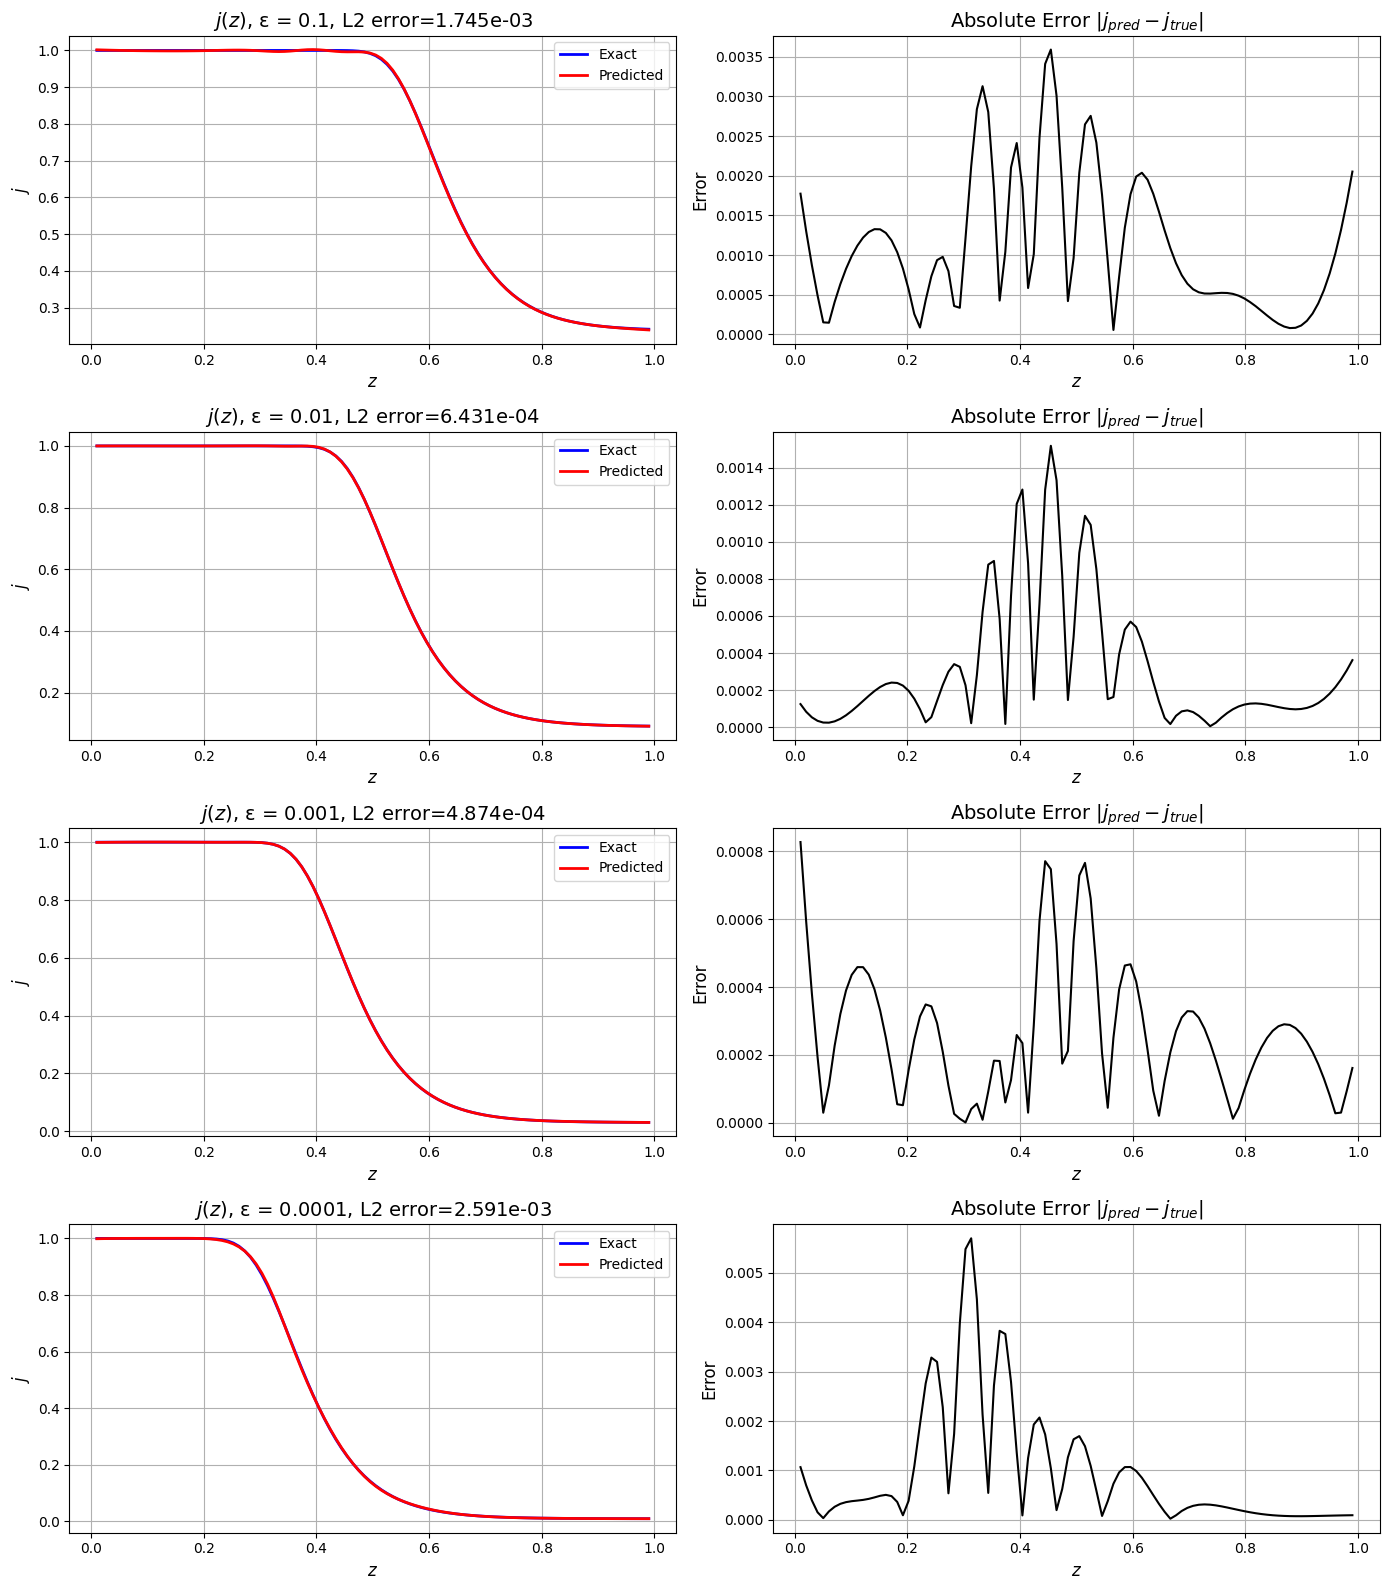

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


In [58]:
def get_J(eps):
    key = random.PRNGKey(123)
    P_test = 100
    N_test = 1
    Nz = 100
    m = Nz

    s_test, z_test, j_test = generate_test_data(key, N_test, P_test, eps)

    # Predict
    params = model.get_params(model.opt_state)
    j_pred = model.predict_j(params, s_test, z_test)

    # Create uniform mesh on [0,1] with Nz points
    z_uniform = np.linspace(0, 1, Nz)
    ZZ = z_uniform[:, None]

    # Grid data (interpolated onto ZZ)
    J_pred = griddata(z_test, j_pred.flatten(), ZZ, method='cubic')
    J_test = griddata(z_test, j_test.flatten(), ZZ, method='cubic')

    # Clean up any NaNs from interpolation
    mask = ~np.isnan(J_pred) & ~np.isnan(J_test)
    ZZ = ZZ[mask].flatten()
    J_pred = J_pred[mask]
    J_test = J_test[mask]
    abs_error = np.abs(J_pred - J_test)
    l2_error = np.linalg.norm(J_pred - J_test, 2) / np.linalg.norm(J_test, 2)

    return ZZ, J_pred, J_test, abs_error, l2_error


def visualize_all():
    # Gather data to be plotted
    draws = [0.1, 0.01, 0.001, 0.0001]
    fig, axs = plt.subplots(len(draws), 2, figsize=(14, 4*len(draws)))

    preds = []

    for i, eps in enumerate(draws):
        # Compute predictions and errors
        ZZ, J_pred, J_test, abs_error, l2_error = get_J(eps)
        preds.append(J_pred)

        # --- Left column: Exact vs Predicted ---
        axs[i, 0].plot(ZZ, J_test, label='Exact', color='blue', linewidth=2)
        axs[i, 0].plot(ZZ, J_pred, label='Predicted', color='red', linewidth=2)
        axs[i, 0].set_title(f"$j(z)$, ε = {eps}, L2 error={l2_error:.3e}", fontsize=14)
        axs[i, 0].set_xlabel('$z$', fontsize=12)
        axs[i, 0].set_ylabel('$j$', fontsize=12)
        axs[i, 0].legend(fontsize=10)
        axs[i, 0].grid(True)

        # --- Right column: Absolute Error ---
        axs[i, 1].plot(ZZ, abs_error, label='|Error|', color='black')
        axs[i, 1].set_title('Absolute Error $|j_{pred} - j_{true}|$', fontsize=14)
        axs[i, 1].set_xlabel('$z$', fontsize=12)
        axs[i, 1].set_ylabel('Error', fontsize=12)
        axs[i, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return preds

predicted = visualize_all()
print((predicted[1]-predicted[0])==0)